In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

os.listdir("/kaggle/input")


['lending-club']

In [2]:
os.listdir("/kaggle/input/lending-club")


['rejected_2007_to_2018Q4.csv.gz',
 'accepted_2007_to_2018Q4.csv.gz',
 'accepted_2007_to_2018q4.csv',
 'rejected_2007_to_2018q4.csv']

In [3]:
import pandas as pd

use_cols = [
    "loan_status",
    "loan_amnt",
    "int_rate",
    "term",
    "grade",
    "sub_grade",
    "annual_inc",
    "dti",
    "fico_range_low",
    "fico_range_high"
]

df = pd.read_csv(
    "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz",
    usecols=use_cols,
    compression="gzip"
)

df = df[df["loan_status"].isin(["Fully Paid", "Charged Off", "Default"])]
df = df.sample(n=200_000, random_state=42)

print(df.shape)
df.head()


(200000, 10)


,loan_amnt,term,int_rate,grade,sub_grade,annual_inc,loan_status,dti,fico_range_low,fico_range_high
1687104,20000.0,36 months,13.99,C,C3,65000.0,Fully Paid,13.68,705.0,709.0
708343,7000.0,36 months,9.16,B,B2,35000.0,Fully Paid,22.39,710.0,714.0
412310,20000.0,36 months,8.67,B,B1,90000.0,Fully Paid,29.14,665.0,669.0
1037866,16000.0,36 months,14.46,C,C4,50000.0,Fully Paid,34.64,660.0,664.0
165271,4000.0,36 months,11.53,B,B5,85000.0,Fully Paid,24.27,700.0,704.0


In [7]:
df.to_csv("credit_risk_sample.csv", index=False)


In [15]:
X = df.drop(columns=["loan_status", "default"])
y = df["default"]


In [8]:
import pandas as pd

df = pd.read_csv("credit_risk_sample.csv")

df["default"] = df["loan_status"].apply(
    lambda x: 1 if x in ["Charged Off", "Default"] else 0
)

df["default"].value_counts(normalize=True)


default
0    0.800575
1    0.199425
Name: proportion, dtype: float64

In [21]:
X = df.drop(columns=["loan_status", "default"])
y = df["default"]


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

log_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
from sklearn.impute import SimpleImputer


In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

log_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.6975877948699676
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     32023
           1       0.53      0.03      0.06      7977

    accuracy                           0.80     40000
   macro avg       0.67      0.51      0.47     40000
weighted avg       0.75      0.80      0.72     40000



In [31]:
from sklearn.tree import DecisionTreeClassifier

tree_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

tree_model.fit(X_train, y_train)

y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_tree))


ROC-AUC: 0.6895062096739255


In [32]:
!pip install xgboost


In [33]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBoost ROC-AUC: 0.7040814802194695


In [34]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "XGBoost"],
    "ROC_AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_tree),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})

results


,Model,ROC_AUC
0,Logistic Regression,0.697588
1,Decision Tree,0.689506
2,XGBoost,0.704081


In [51]:
df_results = X_test.copy()
df_results["y_true"] = y_test.values
df_results["y_pred_prob_xgb"] = y_prob_xgb


In [52]:
!pip install shap


In [54]:
# Get fitted preprocessor and model
preprocessor = xgb_model.named_steps["preprocess"]
xgb_clf = xgb_model.named_steps["model"]

# Transform test data
X_test_transformed = preprocessor.transform(X_test)


In [55]:
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_transformed)


ValueError: could not convert string to float: '[1.99425E-1]'

In [56]:
ValueError: could not convert string to float: '[1.99425E-1]'


SyntaxError: invalid syntax (1434199800.py, line 1)

In [57]:
import shap

# Transform training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Use the new unified explainer
explainer = shap.Explainer(
    xgb_clf,
    X_train_transformed,
    feature_names=(
        list(num_cols) +
        list(
            preprocessor.named_transformers_["cat"]
            .named_steps["encoder"]
            .get_feature_names_out(cat_cols)
        )
    )
)

shap_values = explainer(X_test_transformed)


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [71]:
import numpy as np
import shap

# Define a callable prediction function for SHAP
def predict_proba_fn(X):
    return xgb_model.predict_proba(X)[:, 1]


In [80]:
# Use a small background sample for speed
background = shap.sample(X_train, 100)

explainer = shap.Explainer(
    predict_proba_fn,
    background,
    feature_names=(
        list(num_cols) +
        list(
            preprocess.named_transformers_["cat"]
            .named_steps["encoder"]
            .get_feature_names_out(cat_cols)
        )
    )
)

shap_values = explainer(X_test[:500])


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [82]:
# Transform train and test data using fitted preprocessor
X_train_t = preprocess.transform(X_train)
X_test_t = preprocess.transform(X_test)


In [90]:
def predict_proba_transformed(X):
    return xgb_clf.predict_proba(X)[:, 1]


In [99]:
import shap

# Use a small numeric background for speed
background = shap.sample(X_train_t, 100)

explainer = shap.Explainer(
    predict_proba_transformed,
    background,
    feature_names=(
        list(num_cols) +
        list(
            preprocess.named_transformers_["cat"]
            .named_steps["encoder"]
            .get_feature_names_out(cat_cols)
        )
    )
)


In [100]:
shap_values = explainer(X_test_t[:300])


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 50) was passed while the masker expected data of shape (50,).

In [116]:
import shap
from shap import maskers


In [118]:
# Background must be 2D numeric
background = shap.sample(X_train_t, 100)

masker = maskers.Independent(background)


In [126]:
explainer = shap.PermutationExplainer(
    predict_proba_transformed,
    masker,
    feature_names=(
        list(num_cols) +
        list(
            preprocess.named_transformers_["cat"]
            .named_steps["encoder"]
            .get_feature_names_out(cat_cols)
        )
    )
)


In [127]:
shap_values = explainer(X_test_t[:200])


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 50) was passed while the masker expected data of shape (50,).

In [130]:
feature_names = (
    list(num_cols) +
    list(
        preprocess.named_transformers_["cat"]
        .named_steps["encoder"]
        .get_feature_names_out(cat_cols)
    )
)


In [132]:
import pandas as pd
import numpy as np

importances = xgb_clf.feature_importances_

fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(15)


,feature,importance
8,grade_A,0.416244
9,grade_B,0.116161
10,grade_C,0.081442
1,int_rate,0.058339
6,term_ 36 months,0.056595
7,term_ 60 months,0.020048
11,grade_D,0.017285
24,sub_grade_B5,0.012852
23,sub_grade_B4,0.009484
26,sub_grade_C2,0.009291


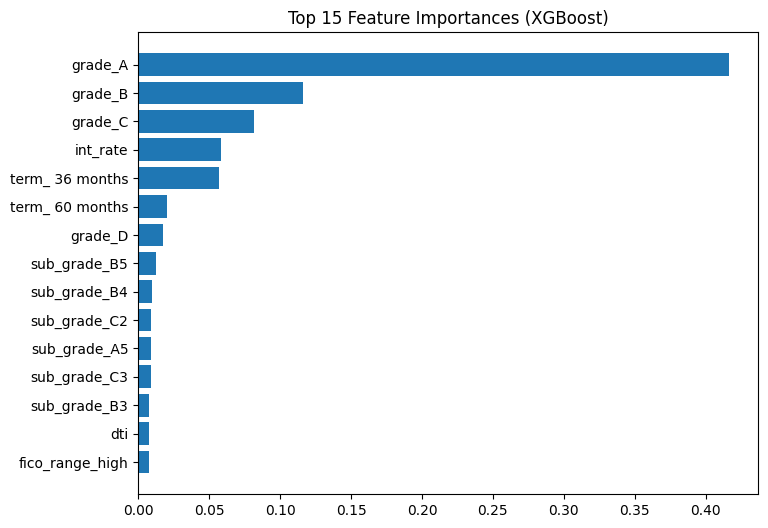

In [133]:
import matplotlib.pyplot as plt

top_fi = fi.head(15)

plt.figure(figsize=(8, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()
